Text(0, 0.5, 'Mouse #')

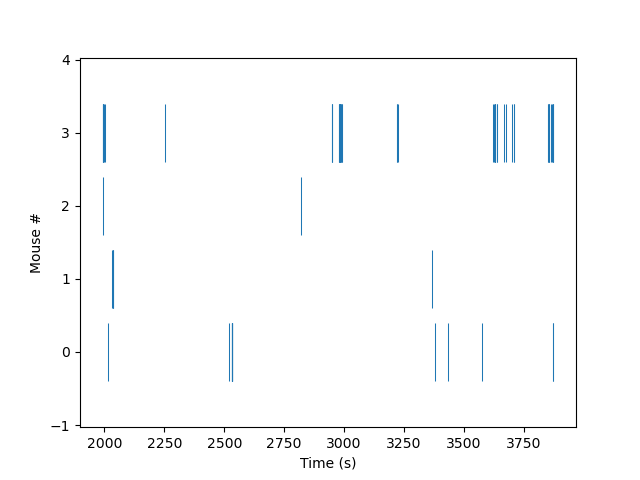

In [1]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pntools import sampled

%matplotlib widget

lick_file = r'C:\Users\prane\Downloads\PhotoM groupe 1\10feb_20220311-144351lick_times.csv'
mouse_names = (1, 2, 3, 4)
mouse_col_offset = 11
bout_th = 10 # s

sig_file = r'C:\Users\prane\Downloads\PhotoM groupe 1\10feb_20220311-144351_GCaMP.csv'
target_sr = 30 # Hz
discard_initial_s = 50 # seconds
detrend_lambda = 2e5
f_bandpass = (0.2, 6)

class Bout:
    def __init__(self, timestamps, th=10):
        self._timestamps = np.asarray(timestamps)
        self.th = th

    def __call__(self):
        return list(self._timestamps)
    
    def __len__(self):
        return len(self._timestamps)

    def bout_classes(self):
        timestamps = self._timestamps
        bout_list = np.zeros(timestamps.size, dtype=int)
        bout_list[0] = 1
        curr_bout = 1
        for sample_count, (prev_stamp, this_stamp) in enumerate(zip(timestamps[:-1], timestamps[1:])):
            if this_stamp - prev_stamp > self.th:
                curr_bout += 1
            bout_list[sample_count+1] = curr_bout
        return bout_list
    
    def bout_start_idx(self):
        return [0] + list(np.where(np.diff(self.bout_classes()) == 1)[0] + 1)
    
    def bout_end_idx(self):
        return list(np.where(np.diff(self.bout_classes()) == 1)[0]) + [len(self)-1]

    def bout_start(self):
        return self._timestamps[self.bout_start_idx()]
    
    def bout_end(self):
        return self._timestamps[self.bout_end_idx()]
    
    def bout_dur(self):
        return self.bout_end() - self.bout_start()
    
    def bout_gap_dur(self):
        return self.bout_start()[1:] - self.bout_end()[:-1]
    
    def n_bouts(self):
        return len(set(self.bout_classes()))
    
    def n_events_per_bout(self):
        return list(Counter(self.bout_classes()).values())
    

df = pd.read_csv(lick_file).to_numpy()
t = df[:, 0]
m_licktimes = dict()
for mouse_count, mouse_name in enumerate(mouse_names):
    m_licktimes[mouse_name] = Bout(t[df[:, mouse_col_offset+mouse_count].astype(bool)], bout_th)

f, ax = plt.subplots(1, 1)
ax.eventplot([x() for x in m_licktimes.values()], linelengths=0.8)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Mouse #')

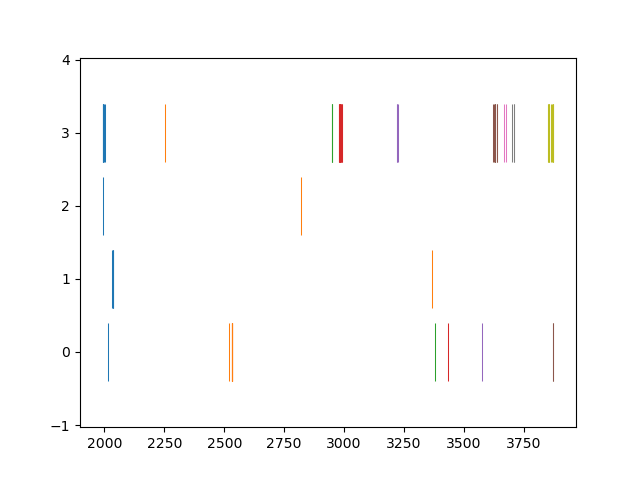

In [3]:
f2, ax2 = plt.subplots(1, 1)
for m_count, this_licktimes in enumerate(m_licktimes.values()):
    bout_classes = this_licktimes.bout_classes()
    for bout_class in np.unique(bout_classes):
        ax2.eventplot(np.asarray(this_licktimes())[bout_classes == bout_class], color=f'C{bout_class-1}', lineoffsets=m_count, linelengths=0.8)

In [4]:
df = pd.read_csv(sig_file)
m_names = [x for x in df.columns.values.tolist() if 'Mouse' in x]
t = df['Timestamp'].to_numpy()

m_data = {}
for m_name in m_names:
    x = sampled.uniform_resample(t, df[m_name].to_numpy(), target_sr)
    m_data[m_name] = x[x._t0 + float(discard_initial_s):]

m = m_data['Mouse10G']

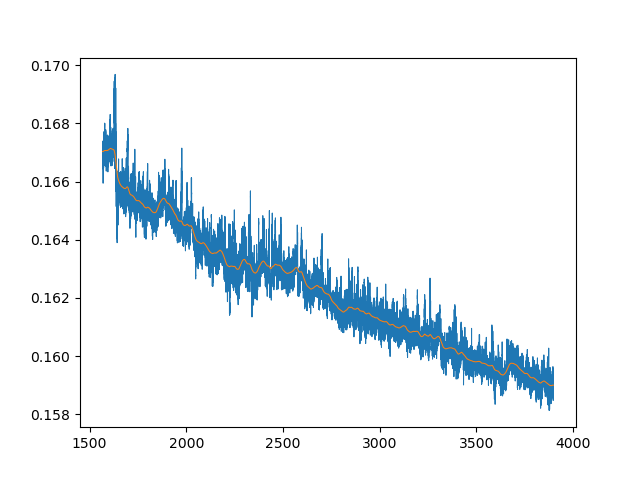

In [5]:
plt.figure()
plt.plot(*m(''))
plt.plot(*m.get_trend_airPLS(detrend_lambda)(''))

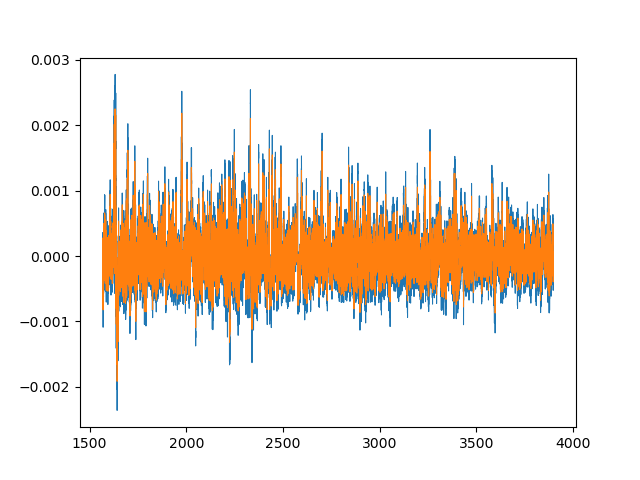

In [6]:
plt.figure()
plt.plot(*m.detrend_airPLS(detrend_lambda)(''))
plt.plot(*m.detrend_airPLS(detrend_lambda).bandpass(*f_bandpass)(''))

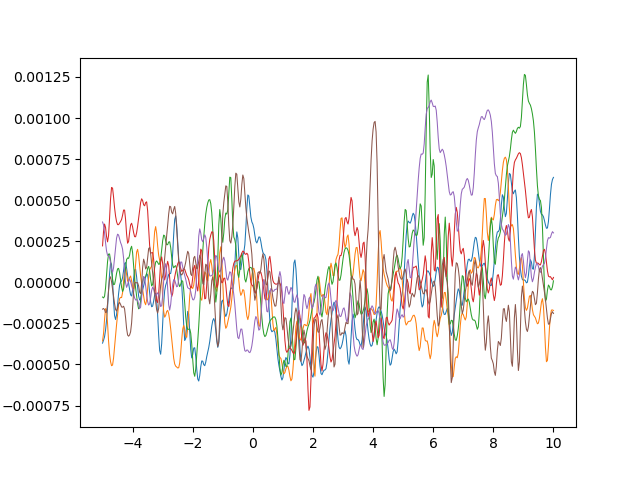

In [13]:
m_proc = m.detrend_airPLS(detrend_lambda).bandpass(*f_bandpass)
m_lickstart = m_licktimes[1]

event_win = sampled.Interval(-5., 10., sr=m_proc.sr)

plt.figure()
for ev_start in m_lickstart.bout_start():
    plt.plot(event_win.t, m_proc[event_win + ev_start]())
